In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Loading Images

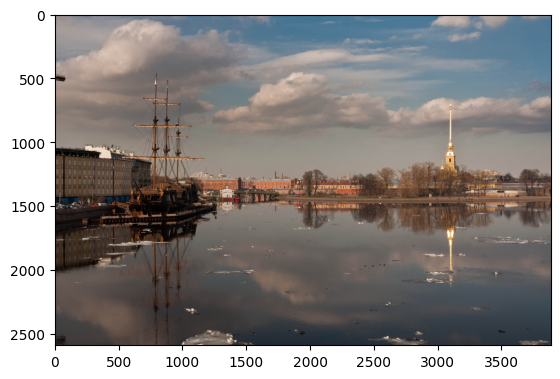

In [25]:
img1 = cv2.imread("boat1.jpg")
img2 = cv2.imread("boat2.jpg")
img3 = cv2.imread("boat3.jpg")
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)
plt.imshow(img1)

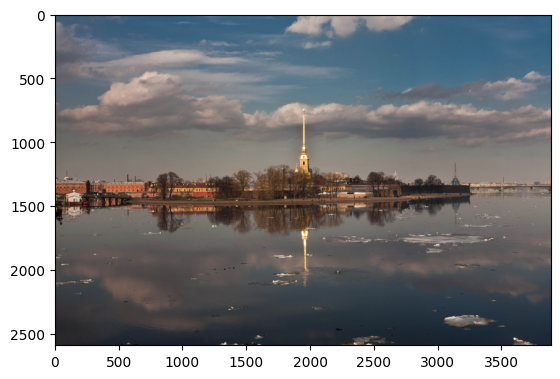

In [26]:
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)
plt.imshow(img2)

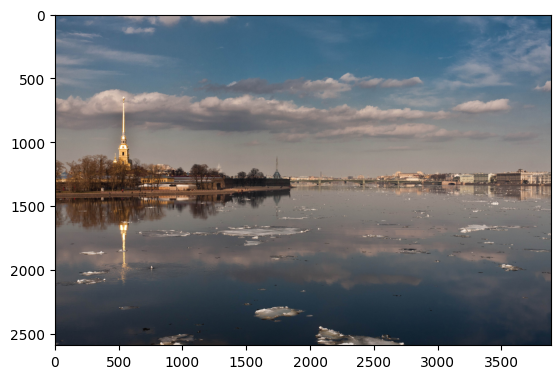

In [27]:
img3 = cv2.cvtColor(img3 , cv2.COLOR_BGR2RGB)
plt.imshow(img3)

In [28]:
def ShiftImage(img, x , y , shape):
    TM = np.array([
        [1 , 0  , x],
        [0 , 1 , y],
        [0 , 0 , 1]
    ] , dtype=np.float32)
    img = cv2.warpPerspective(img , TM , shape)
    return img

In [29]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1 , crossCheck = False)

Genrating keypoints and performing raw matching

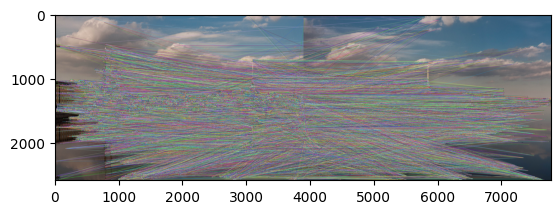

In [30]:
kp1 , des1 = sift.detectAndCompute(img1 , None)
kp2 , des2 = sift.detectAndCompute(img2 , None)
matchingleft2mid = bf.knnMatch(des1 , des2 , k = 2)
drawMatchleft2mid = cv2.drawMatchesKnn(img1 , kp1 , img2 , kp2 , matchingleft2mid , None)
plt.imshow(drawMatchleft2mid)

Good Matches 

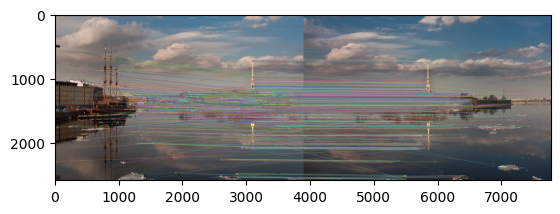

In [31]:
def GenrateGoodKeyPoints(rawMatches):
    goodKeypoints = []
    goodMatches = []
    for m1 , m2 in rawMatches:
        if m1.distance < 0.8 * m2.distance:
            goodMatches.append([m1])
            goodKeypoints.append((m1.trainIdx , m1.queryIdx))
    return goodMatches , goodKeypoints
        
left2midMatches , left2midKeypoints = GenrateGoodKeyPoints(matchingleft2mid)

plt.imshow(cv2.drawMatchesKnn(img1 , kp1 , img2 , kp2 , left2midMatches , None , flags=2))

Computing Transformation (Homography)

In [32]:
img1kp = np.array([kp1[i].pt for (_ , i) in left2midKeypoints])
img2kp = np.array([kp2[i].pt for (i , _) in left2midKeypoints])
H21 , status = cv2.findHomography(np.float32(img2kp), np.float32(img1kp) , cv2.RANSAC , 5.0)
H21

array([[ 8.05967694e-01, -1.41521526e-03,  1.22221227e+03],
       [-6.29057949e-02,  9.35957533e-01,  6.21726448e+01],
       [-5.11939121e-05,  1.78416868e-06,  1.00000000e+00]])

Perspective transformations of the desination keypoint images and computing panoramic view

(2592, 7776, 3)

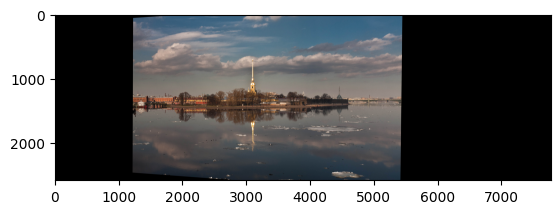

In [54]:
img2_transformed = cv2.warpPerspective(img2 , H21, (img1.shape[1] + img2.shape[1], img1.shape[0]))
plt.imshow(img2_transformed , cmap="gray")
img2_transformed.shape

In [34]:
# img2_transformed = np.zeros_like(img1_transformed)
# img2_transformed.shape

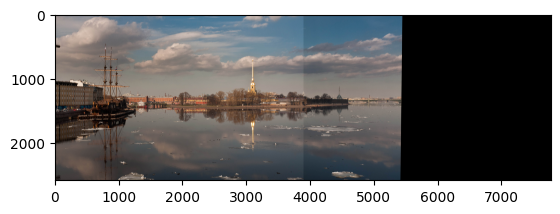

In [84]:
img2_transformed[:img2.shape[0],:img2.shape[1]] = img1
img_res1 = img2_transformed
plt.imshow(img_res1 , cmap="gray")

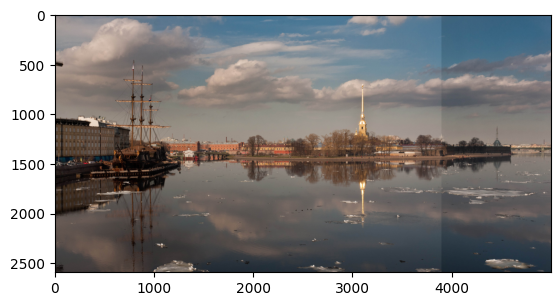

In [85]:
p21 = img_res1[:,:5000]
plt.imshow(p21)

blending image

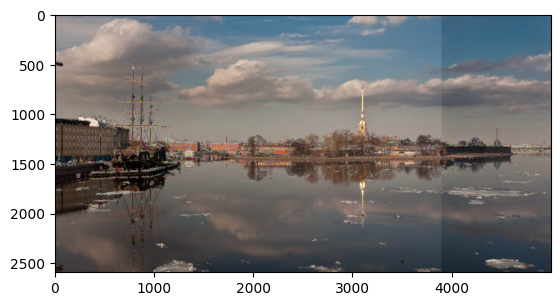

In [86]:
kp1 , des1 = sift.detectAndCompute(p21 , None)
plt.imshow(cv2.drawKeypoints(p21 , kp1 , None))

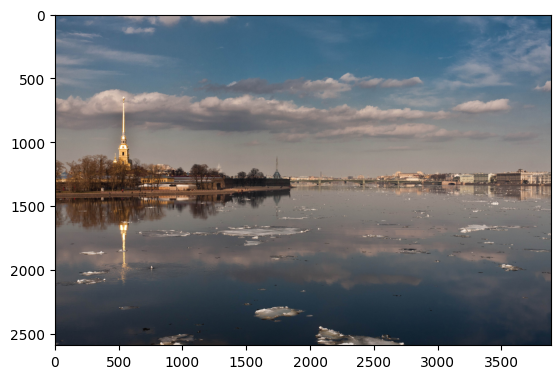

In [87]:
plt.imshow(img3)

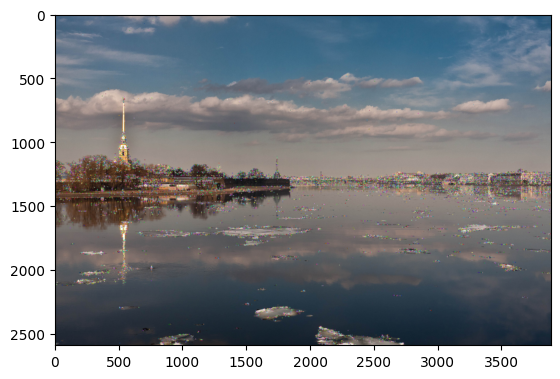

In [44]:
kp2 , des2 = sift.detectAndCompute(img3 , None)
plt.imshow(cv2.drawKeypoints(img3 , kp2 , None))

In [88]:
rawMatching = bf.knnMatch(des1 , des2 , k = 2)
goodMatches , goodKeypointIndex = GenrateGoodKeyPoints(rawMatching)

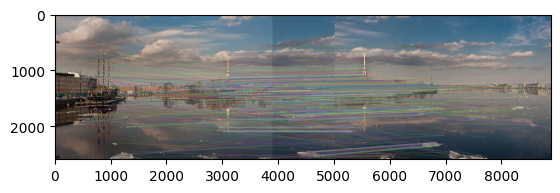

In [89]:
plt.imshow(cv2.drawMatchesKnn(p21 , kp1 , img3 , kp2 , goodMatches , None))

In [90]:
img1_kp = np.array([kp1[i].pt for (_ , i) in goodKeypointIndex]) # stores all the good keypoints of kp1 
img2_kp = np.array([kp2[i].pt for (i, _) in goodKeypointIndex]) # stores all the good keypoints of kp2

In [91]:
H , status = cv2.findHomography(np.float32(img2_kp), np.float32(img1_kp) , cv2.RANSAC , 5.0)
H

array([[ 5.73815956e-01, -2.34583347e-02,  2.60476966e+03],
       [-1.48551691e-01,  9.08985409e-01,  1.53671472e+02],
       [-1.07368145e-04, -8.41946123e-06,  1.00000000e+00]])

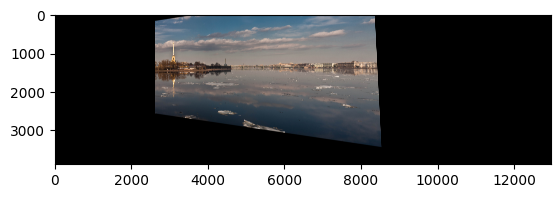

In [92]:
RightPanorama = cv2.warpPerspective(img3.copy() , H , ((img3.shape[0] + img3.shape[1])*2 , img3.shape[1]))
plt.imshow(RightPanorama)

resultant panorama

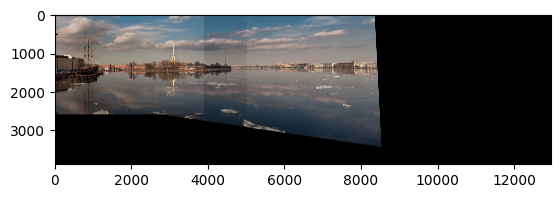

In [94]:
RightPanorama[:p21.shape[0],:p21.shape[1]] = p21
img_res2 = RightPanorama
plt.imshow(img_res2)

shrinking the mask . But not cropping the image

True

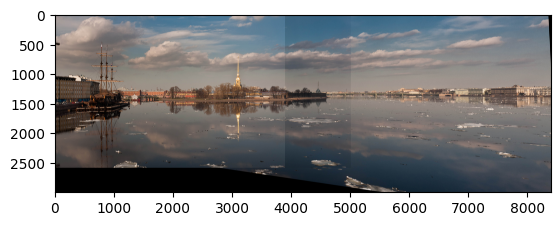

In [96]:
res = img_res2[:3000,:8400]
plt.imshow(res)
cv2.imwrite("Output.png" , res)

performing some cropping

True

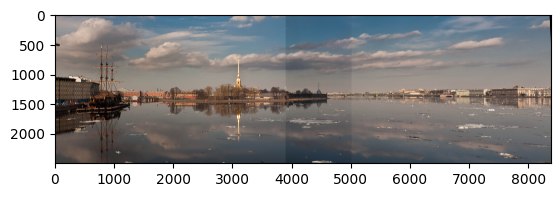

In [104]:
res = img_res2[:2500,:8380]
plt.imshow(res)
res = cv2.cvtColor(res , cv2.COLOR_BGR2RGB)
cv2.imwrite("croppedRes.png" , res)